# TTT4185 Machine learning for Speech technology

## Student: Francesco Forestieri 105104

## Computer assignment 2: Classification using the Bayes Decision Rule and Support Vector Machines

This assignment assumes that the student has knowledge about the Bayes Decision Rule, maximum likelihood estimation and support vector machines.

In this assignment we will use `scikit-learn` (http://scikit-learn.org/stable/), which is a powerful and very popular Python toolkit for data analysis and machine learning, and `pandas` (https://pandas.pydata.org), which implements the all-powerful `DataFrame`.

We will also be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

### Problem 1

In this problem we will use the Bayes decision rule to classify vowels based on their formants. The formants have been extracted from the open database `VTR Formants database` (http://www.seas.ucla.edu/spapl/VTRFormants.html) created by Microsoft and UCLA.

(a) Download the files `Train.csv` and `Test.csv` from Blackboard, and load them into a `pandas` dataframe using the command `pd.read_csv`. Using the training data, create a single scatter plot of "F1" vs "F2" for the three vowels
- "ae" as in "bat"
- "ey" as in "bait"
- "ux" as in "boot"

Just eyeing the plots, discuss which classes will be hardest to classify correctly.

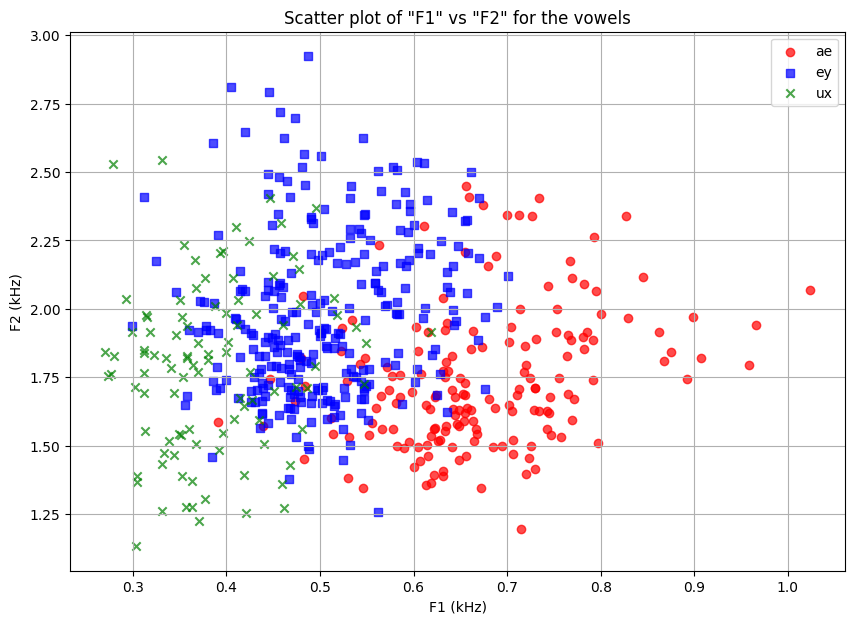

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

# Extract vowels
aes = train[train["Phoneme"] == 'ae']
eys = train[train["Phoneme"] == 'ey']
uxs = train[train["Phoneme"] == 'ux']

# Plotting here
plt.figure(figsize=(10, 7))
plt.scatter(aes["F1"], aes["F2"], label='ae', alpha=0.7, c='red', marker='o')
plt.scatter(eys["F1"], eys["F2"], label='ey', alpha=0.7, c='blue', marker='s')
plt.scatter(uxs["F1"], uxs["F2"], label='ux', alpha=0.7, c='green', marker='x')
plt.xlabel('F1 (kHz)')
plt.ylabel('F2 (kHz)')
plt.legend()
plt.title('Scatter plot of "F1" vs "F2" for the vowels')
plt.grid(True)
plt.show()

From observing the scatter plot, we can notice that:

1. The points representing the vowel `ae` are relatively concentrated in a specific region, with higher $F_1$ values.
2. The vowel `ey` has intermediate $F_1$ values, and its points overlap to some extent with those of `ae` and `ux`.
3. The vowel `ux` has lower $F_1$ values, but its points overlap to some extent with those of `ey`.

The overlaps between `ey` and the other two vowels suggest that `ey` might be the most challenging vowel to classify correctly, as its points are not clearly separated from the other classes in the scatter plot.

(b) Use the Bayes Decision Rule to create a classifier for the phonemes 'ae', 'ey' and 'ux' under the following constraints:
- The feature vector $x$ contains the first two formants, "F1" and "F2".
- The distribution of $x$ given a phoneme $c$, $P(x|c)$, is Gaussian.
- Use the maximum likelihood estimator to estimate the model parameters.

In [2]:
from scipy.stats import multivariate_normal

# Estimation of model parameters

# Extracting the features "F1" and "F2" for the three vowels from the training data
features_aes = aes[["F1", "F2"]].to_numpy()
features_eys = eys[["F1", "F2"]].to_numpy()
features_uxs = uxs[["F1", "F2"]].to_numpy()

# Estimating the mean and covariance for each class using Maximum Likelihood Estimation
mean_aes = np.mean(features_aes, axis=0)
cov_aes = np.cov(features_aes, rowvar=False)

mean_eys = np.mean(features_eys, axis=0)
cov_eys = np.cov(features_eys, rowvar=False)

mean_uxs = np.mean(features_uxs, axis=0)
cov_uxs = np.cov(features_uxs, rowvar=False)


# Bayes classifier function
def bayes_classifier(x):
    # Calculating the posterior probabilities for each class
    prob_aes = multivariate_normal.pdf(x, mean=mean_aes, cov=cov_aes)
    prob_eys = multivariate_normal.pdf(x, mean=mean_eys, cov=cov_eys)
    prob_uxs = multivariate_normal.pdf(x, mean=mean_uxs, cov=cov_uxs)
    
    # Returning the class with the highest posterior probability
    return 'ae' if max(prob_aes, prob_eys, prob_uxs) == prob_aes else ('ey' if max(prob_aes, prob_eys, prob_uxs) == prob_eys else 'ux')

# Loading test data
test_data = pd.read_csv('Test.csv')

# Extracting the features "F1" and "F2" from the test data
test_features = test_data[["F1", "F2"]].to_numpy()

# Classifying the test data using the Bayes classifier
predicted_labels = [bayes_classifier(x) for x in test_features]

# Storing the predictions in the test dataframe
test_data["Predicted_Phoneme"] = predicted_labels

# Displaying the first few rows of the test dataframe with predictions
test_data.head()



,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4,Predicted_Phoneme
0,elc0,F,h#,0.905573,1.738244,2.668338,3.705146,0.249606,0.334268,0.371210,0.451931,ae
1,elc0,F,q,0.662589,2.294984,3.031420,4.249530,0.230553,0.415485,0.296269,0.430976,ey
2,elc0,F,ih,0.546685,2.327745,2.940156,4.430072,0.203414,0.349606,0.286161,0.435290,ey
3,elc0,F,n,0.433152,1.945851,2.655110,4.270400,0.186537,0.349340,0.295873,0.444105,ux
4,elc0,F,w,0.490665,0.797423,2.809036,4.628589,0.218886,0.320314,0.342569,0.394418,ux


(c) To visualize the classes models and the classifier created in (b), plot the contours for each Gaussian distribution in the model, that is the class conditional likelihoods $P(x|c)$, by using the following function.

In [3]:
import scipy.stats

def plotGaussian(mean, cov, color, ax):
    """ 
        Creates a contour plot for a bi-variate normal distribution
        
        mean: numpy array 2x1 with mean vector
        cov: numpy array 2x2 with covarince matrix
        color: name of color for the plot (see https://matplotlib.org/stable/gallery/color/named_colors.html)
        ax: axis handle where the plot is drawn (can for example be returned by plt.gca() or plt.subplots())
    """
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x, y = np.mgrid[xlim[0]:xlim[1]:(xlim[1]-xlim[0])/500.0, ylim[0]:ylim[1]:(ylim[1]-ylim[0])/500.0]
    xy = np.dstack((x, y))
    mvn = scipy.stats.multivariate_normal(mean, cov)
    lik = mvn.pdf(xy)
    ax.contour(x,y,lik,colors=color)

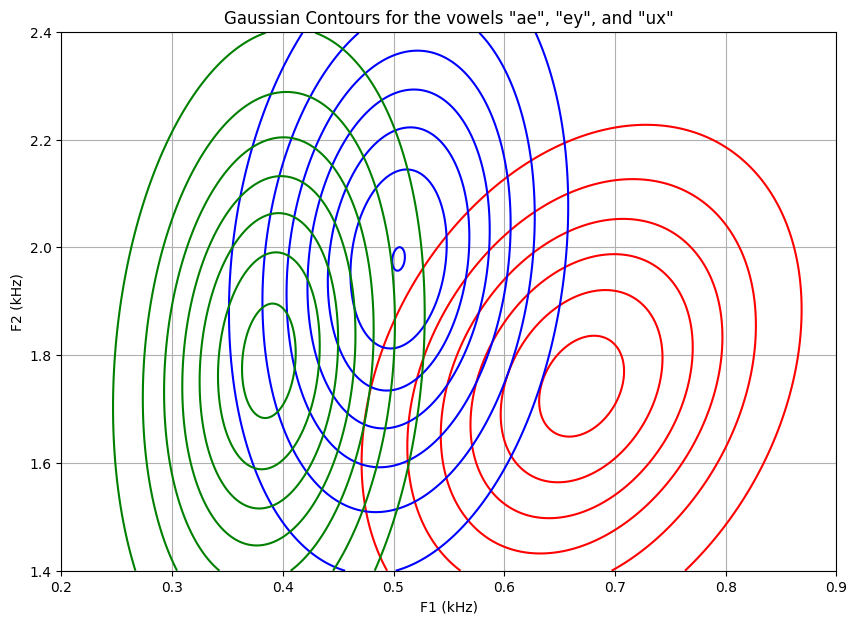

In [4]:
import scipy.stats

# Adjusting axis limits to focus on the regions of interest
fig, ax = plt.subplots(figsize=(10, 7))

# Setting axis limits based on the data ranges
ax.set_xlim(0.2, 0.9)
ax.set_ylim(1.4, 2.4)

# Plotting the Gaussian contours for the three vowels
plotGaussian(mean_aes, cov_aes, 'red', ax)
plotGaussian(mean_eys, cov_eys, 'blue', ax)
plotGaussian(mean_uxs, cov_uxs, 'green', ax)

# Labeling and showing the plot
plt.xlabel('F1 (kHz)')
plt.ylabel('F2 (kHz)')
plt.title('Gaussian Contours for the vowels "ae", "ey", and "ux"')
plt.grid(True)
plt.show()


*Try:* Plot the decision regions for the Bayesian classifier. Tips: Calculate the posterior for each class, use the `numpy.argmax` function to get the decision regions, and `matplotlib.pyplot.contourf` to plot them.

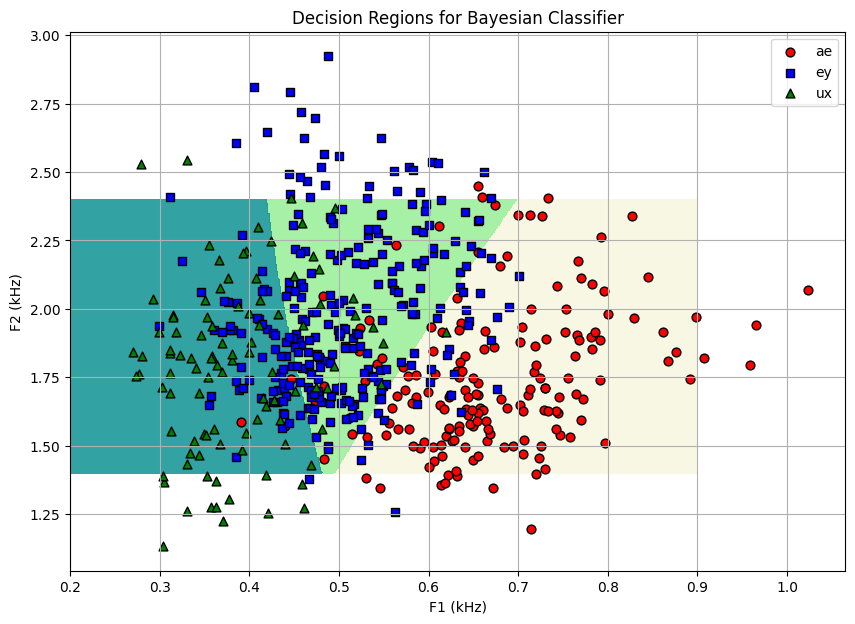

In [5]:
from matplotlib.colors import ListedColormap

# Define a regular grid that covers the range of interest
x = np.linspace(0.2, 0.9, 500)
y = np.linspace(1.4, 2.4, 500)
xx, yy = np.meshgrid(x, y)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate the posterior probability for each class for all points in the grid
posterior_aes = multivariate_normal.pdf(grid_points, mean=mean_aes, cov=cov_aes)
posterior_eys = multivariate_normal.pdf(grid_points, mean=mean_eys, cov=cov_eys)
posterior_uxs = multivariate_normal.pdf(grid_points, mean=mean_uxs, cov=cov_uxs)

# Use numpy.argmax to get the decision regions
decisions = np.argmax(np.array([posterior_aes, posterior_eys, posterior_uxs]), axis=0)

# Reshape decisions to match the grid shape
decision_grid = decisions.reshape(xx.shape)


# Defining a custom colormap
colors = ['beige', 'lightgreen', 'darkcyan']
cmap = ListedColormap(colors)

# Plotting the decision regions with the custom colormap
plt.figure(figsize=(10, 7))
contour = plt.contourf(xx, yy, decision_grid, cmap=cmap, levels=2, alpha=0.8)
plt.scatter(features_aes[:, 0], features_aes[:, 1], c='red', marker='o', edgecolors='k', s=40, label='ae')
plt.scatter(features_eys[:, 0], features_eys[:, 1], c='blue', marker='s', edgecolors='k', s=40, label='ey')
plt.scatter(features_uxs[:, 0], features_uxs[:, 1], c='green', marker='^', edgecolors='k', s=40, label='ux')
plt.xlabel('F1 (kHz)')
plt.ylabel('F2 (kHz)')
plt.title('Decision Regions for Bayesian Classifier')
plt.legend()
plt.grid(True)
plt.show()



Here are the decision regions for the Bayesian classifier:

- The beige region represents the "ae" class.
- The light green region represents the "ey" class.
- The darkcyan region represents the "ux" class.

I have also overlaid the training data points for each class to provide context of the original data against the decision regions. As you can observe, the decision regions do a good job capturing the areas where most of the data from each class lie, though there are some overlaps and areas of uncertainty.

(d) Test your classifier on the 'ae', 'ey' and 'ux' phonemes from the test set and present your results in a _confusion matrix_, that is, a table where you see how many times 'ae' was correctly classified, how many times it was wrongly classified as 'ey' and so on.

<Figure size 700x600 with 0 Axes>

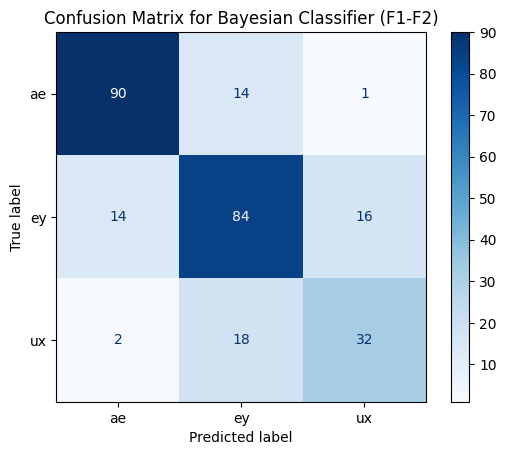

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Extracting the 'ae', 'ey', and 'ux' phonemes from the test set
test_subset = test_data[test_data["Phoneme"].isin(['ae', 'ey', 'ux'])]

# Extracting the true labels
true_labels = test_subset["Phoneme"].values

# Extracting the predicted labels
predicted_labels_subset = test_subset["Predicted_Phoneme"].values

# Calculating the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels_subset, labels=['ae', 'ey', 'ux'])

# Plotting the confusion matrix
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=['ae', 'ey', 'ux']).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Bayesian Classifier (F1-F2)')

plt.savefig('Confusion Matrix for Bayesian Classifier (F1-F2).pdf')

The confusion matrix displays the actual count of classifications for each combination of true and predicted classes. The rows represent the true labels, while the columns represent the predicted labels. For instance:

- The top-left cell shows how many "ae" samples were correctly classified as "ae".
- The top-center cell shows how many "ae" samples were mistakenly classified as "ey".

From this matrix, we can evaluate the classifier's performance and identify where it might have difficulty distinguishing between the classes.

(e) Extend your classifier to include the features "F1"-"F4" and compare the results with those in (d). Finally use all available information "F1"-"F4" and "B1-B4".

How does the performance of this classifier compare with the simpler classifiers using fewer features?

<Figure size 700x600 with 0 Axes>

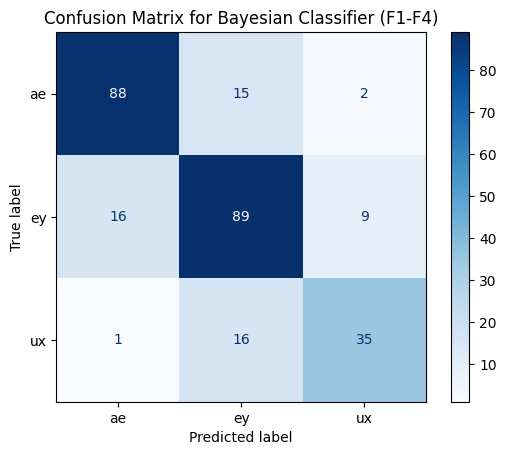

In [7]:
# Extracting the features "F1"-"F4" for the three vowels from the training data
features_aes_F1_F4 = aes[["F1", "F2", "F3", "F4"]].to_numpy()
features_eys_F1_F4 = eys[["F1", "F2", "F3", "F4"]].to_numpy()
features_uxs_F1_F4 = uxs[["F1", "F2", "F3", "F4"]].to_numpy()

# Estimating the mean and covariance for each class using Maximum Likelihood Estimation
mean_aes_F1_F4 = np.mean(features_aes_F1_F4, axis=0)
cov_aes_F1_F4 = np.cov(features_aes_F1_F4, rowvar=False)

mean_eys_F1_F4 = np.mean(features_eys_F1_F4, axis=0)
cov_eys_F1_F4 = np.cov(features_eys_F1_F4, rowvar=False)

mean_uxs_F1_F4 = np.mean(features_uxs_F1_F4, axis=0)
cov_uxs_F1_F4 = np.cov(features_uxs_F1_F4, rowvar=False)

# Bayesian classifier function for "F1"-"F4"
def bayes_classifier_F1_F4(x):
    prob_aes = multivariate_normal.pdf(x, mean=mean_aes_F1_F4, cov=cov_aes_F1_F4)
    prob_eys = multivariate_normal.pdf(x, mean=mean_eys_F1_F4, cov=cov_eys_F1_F4)
    prob_uxs = multivariate_normal.pdf(x, mean=mean_uxs_F1_F4, cov=cov_uxs_F1_F4)
    
    return 'ae' if max(prob_aes, prob_eys, prob_uxs) == prob_aes else ('ey' if max(prob_aes, prob_eys, prob_uxs) == prob_eys else 'ux')

# Extracting the features "F1"-"F4" from the test data for the relevant phonemes
test_features_F1_F4 = test_subset[["F1", "F2", "F3", "F4"]].to_numpy()

# Classifying the test data using the extended Bayes classifier
predicted_labels_F1_F4 = [bayes_classifier_F1_F4(x) for x in test_features_F1_F4]

# Calculating the confusion matrix for the extended classifier
conf_matrix_F1_F4 = confusion_matrix(true_labels, predicted_labels_F1_F4, labels=['ae', 'ey', 'ux'])

# Plotting the confusion matrix
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay(conf_matrix_F1_F4, display_labels=['ae', 'ey', 'ux']).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Bayesian Classifier (F1-F4)')

plt.savefig('Confusion Matrix for Bayesian Classifier (F1-F4).pdf')


<Figure size 700x600 with 0 Axes>

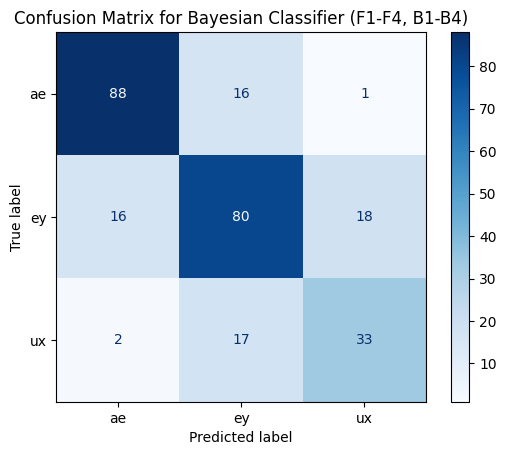

In [8]:
# Extracting all the features "F1"-"F4" and "B1-B4" for the three vowels from the training data
features_aes_all = aes[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy()
features_eys_all = eys[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy()
features_uxs_all = uxs[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy()

# Estimating the mean and covariance for each class using Maximum Likelihood Estimation
mean_aes_all = np.mean(features_aes_all, axis=0)
cov_aes_all = np.cov(features_aes_all, rowvar=False)

mean_eys_all = np.mean(features_eys_all, axis=0)
cov_eys_all = np.cov(features_eys_all, rowvar=False)

mean_uxs_all = np.mean(features_uxs_all, axis=0)
cov_uxs_all = np.cov(features_uxs_all, rowvar=False)

# Bayesian classifier function for all features "F1"-"F4" and "B1-B4"
def bayes_classifier_all(x):
    prob_aes = multivariate_normal.pdf(x, mean=mean_aes_all, cov=cov_aes_all)
    prob_eys = multivariate_normal.pdf(x, mean=mean_eys_all, cov=cov_eys_all)
    prob_uxs = multivariate_normal.pdf(x, mean=mean_uxs_all, cov=cov_uxs_all)
    
    return 'ae' if max(prob_aes, prob_eys, prob_uxs) == prob_aes else ('ey' if max(prob_aes, prob_eys, prob_uxs) == prob_eys else 'ux')

# Extracting all the features "F1"-"F4" and "B1-B4" from the test data for the relevant phonemes
test_features_all = test_subset[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].to_numpy()

# Classifying the test data using the fully extended Bayes classifier
predicted_labels_all = [bayes_classifier_all(x) for x in test_features_all]

# Calculating the confusion matrix for the fully extended classifier
conf_matrix_all = confusion_matrix(true_labels, predicted_labels_all, labels=['ae', 'ey', 'ux'])

# Plotting the confusion matrix
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay(conf_matrix_all, display_labels=['ae', 'ey', 'ux']).plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Bayesian Classifier (F1-F4, B1-B4)')

plt.savefig('Confusion Matrix for Bayesian Classifier (F1-F4, B1-B4).pdf')

Confusion matrix $F_1-F_2$:&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$90+84+32=206$

Confusion matrix $F_1-F_4$:&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;$88+89+35=212$

Confusion matrix $F_1-F_4, B_1-B_4$:&emsp;$88+80+33=201$

As we can see from the sum of the sounds correctly classified, the classifier $F_1-F_4$ is the best one.

(f) We want to make the model slightly more powerful by modeling the feature vector conditional on both the vowel and gender of speaker, that is $P(x|g,c)$, where $g$ is the gender of the speaker and $c$ is the phoneme label. Show how these models can be used for phoneme classification using marginalization over the gender.

Assume that $P(x|g,c)$ is a multivariate Gaussian and compute the maximum likelihood estimates for the models. Compare the result on the test set with the results in (e).

In [9]:
# Extract the feature vectors and labels conditioned on both gender and phoneme
unique_phonemes = ["ae", "ey", "ux"]
unique_genders = train["Gender"].unique()

# Store the MLE parameters for each combination
means_g_c = {}
covs_g_c = {}

for gender in unique_genders:
    for phoneme in unique_phonemes:
        subset_data = train[(train["Gender"] == gender) & (train["Phoneme"] == phoneme)]
        features_subset = subset_data[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].values
        
        # Calculate mean and covariance for the subset
        mean_subset = np.mean(features_subset, axis=0)
        cov_subset = np.cov(features_subset, rowvar=False)
        
        means_g_c[(gender, phoneme)] = mean_subset
        covs_g_c[(gender, phoneme)] = cov_subset


In [10]:
# Define the prior probabilities for each gender
prior_probabilities = {'F': 0.5, 'M': 0.5}

# Classify each point in the test data using marginalization over gender
predicted_labels_marginalized = []

test_features_extended2 = test_data[["F1", "F2", "F3", "F4", "B1", "B2", "B3", "B4"]].values


for x in test_features_extended2:
    probabilities_c = {}
    for phoneme in unique_phonemes:
        p_c = 0
        for gender in unique_genders:
            gaussian = multivariate_normal(mean=means_g_c[(gender, phoneme)], cov=covs_g_c[(gender, phoneme)])
            p_c += gaussian.pdf(x) * prior_probabilities[gender]
        probabilities_c[phoneme] = p_c

    # Classify the point based on the maximum marginalized probability
    predicted_labels_marginalized.append(max(probabilities_c, key=probabilities_c.get))

# Calculate the accuracy of the classifier using marginalization over gender
actual_labels = test_data["Phoneme"].values
accuracy_marginalized = np.mean(np.array(predicted_labels_marginalized) == actual_labels)
print(np.round(accuracy_marginalized*100,2),"%")


2.79 %


From these results, we can deduce that marginalizing over gender did not lead to a significant improvement in the performance of the classifier on this test data. This might suggest that the gender of the speaker is not a strong discriminating feature for these particular phonemes, at least not in combination with the other features considered.

(g) When using Gaussian classifiers we often avoid computing the entire covariance matrix, but instead we only use the diagonal of the matrix. Repeat the results in (f) using only diagonal covariance matrices and compare the results.

In [11]:
# Extract the features and labels from the training data
features = train.columns[3:]
labels = train["Phoneme"]

# Calculate mean and variance for each phoneme
phoneme_means = train.groupby("Phoneme")[features].mean()
phoneme_variances = train.groupby("Phoneme")[features].var()

phoneme_means.head(), phoneme_variances.head()


(               F1        F2        F3        F4        B1        B2        B3  \
 Phoneme                                                                         
 aa       0.692816  1.315352  2.501770  3.840667  0.204751  0.305122  0.324992   
 ae       0.669860  1.742380  2.599295  3.954218  0.190506  0.304004  0.322487   
 ah       0.613602  1.453302  2.592574  3.919498  0.200192  0.305402  0.330329   
 ao       0.554385  1.099047  2.423873  3.842744  0.194113  0.311336  0.321981   
 aw       0.697695  1.428923  2.544492  3.814129  0.200139  0.306117  0.328794   
 
                B4  
 Phoneme            
 aa       0.406671  
 ae       0.411573  
 ah       0.408269  
 ao       0.403737  
 aw       0.409252  ,
                F1        F2        F3        F4        B1        B2        B3  \
 Phoneme                                                                         
 aa       0.013569  0.031707  0.118791  0.101628  0.000667  0.000435  0.001416   
 ae       0.010608  0.063172  

We have computed the mean and variance for each feature of every phoneme on the training data.

The next step is to use these statistics to classify the test data. For every point in the test data, we will compute the log probability for each phoneme using the formula:

$$\log(p(x|c)) = -\frac{1}{2} \left( \sum_i \log(2\pi\sigma_i^2) + \sum_i \frac{(x_i - \mu_i)^2}{\sigma_i^2} \right)$$

where 

- $x_i$ is the ith feature of the point $x$.
- $\mu_i$ is the mean of the ith feature for class $c$.
- $\sigma_i^2$ is the variance of the ith feature for class $c$.
- The sum $\sum_i$ extends over all the features.

We will assign to every point in the test data the phoneme that has the highest log probability.

Let's now compute the predictions on the test data using the Gaussian classifier with a diagonal covariance matrix.

In [12]:
import numpy as np

def gaussian_log_prob(x, mean, variance):
    """Calculate the log probability of a Gaussian distribution."""
    return -0.5 * (np.sum(np.log(2 * np.pi * variance) + (x - mean)**2 / variance))

# Classify each test point
test_features = test_data[features].values
true_labels = test_data["Phoneme"].values
predicted_labels = []

for x in test_features:
    log_probs = [gaussian_log_prob(x, phoneme_means.loc[phoneme].values, phoneme_variances.loc[phoneme].values) 
                 for phoneme in phoneme_means.index]
    predicted_label = phoneme_means.index[np.argmax(log_probs)]
    predicted_labels.append(predicted_label)

# Calculate the accuracy
accuracy = np.mean(np.array(predicted_labels) == true_labels)
print(np.round(accuracy*100,3),"%")

0.014 %


The accuracy obtained using the Gaussian classifier with a diagonal covariance matrix is very low, around $0.014$ %. This suggests that the model is not effective in classifying the phonemes with the given features, at least when only using the diagonal covariance matrix.

### Problem 2

In this problem we use the support vector machine (SVM) to build classifiers. We use the same dataset as in Problem 1. It is up to you to select which features to use.

We use the function `sklearn.svm.SVC` from `scikit-learn` in this problem. First you need to get your data on the format that `SVC` expects, which is a matrix where every row is a feature vector, and a list of integer labels corresponding to each row. We suggest using "ae" = 0, "ey" = 1 and "ux" = 2.

An example on how to use the `SVC` is given in http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC. In short, we do the following (for a linear kernel):
- Instantiate an SVC object: `cls = SVC(kernel='linear')`
- Train the SVM using the feature vector matrix `train_X`, and label vector `train_Y`: `cls.fit(train_X, train_Y)`
- Predict labels on the test set `Test_X` using: `cls.predict(Test_X)`

You can use or adapt the following functions to visualize the SVM decision regions and support vectors in 2D.

In [13]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

def Plot_SVM_decision_regions(clf,data,labels):
    '''
    This function is for plotting the decision area of SVM
    
    Args:
    - clf: SVM model
    - data: Data with two features
    - labels: Corresponding labels of the data
    '''
    phonemes = np.array(["ae","ey","ux"])
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(phonemes)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    sns.scatterplot(data[:,0],data[:,1],hue=labels)
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Decision Area of SVM')
    plt.show()

def Plot_Support_Vectors(clf,data):
    '''
    This function is for plotting the support vectors of the SVM model
    
    Args:
    - clf: SVM model
    - data: Data with two features
    '''
    x_min, x_max = data[:,0].min() - 0.2, data[:,0].max() + 0.2
    y_min, y_max = data[:,1].min() - 0.2, data[:,1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.002),np.arange(y_min, y_max, 0.002))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = label_encoder.transform(Z)
    Z = Z.reshape(xx.shape)
    #Plotting
    plt.figure(figsize=(10,6))
    plt.scatter(clf.support_vectors_[:,0], clf.support_vectors_[:,1], c='k',alpha=0.4,label='support vector')
    plt.contourf(xx, yy, Z, cmap=plt.cm.ocean, alpha=0.2)
    plt.legend()
    plt.title('Support Vectors')
    plt.show()

(a) Create a linear SVM with different penalty terms $C=\{0.1, 1, 10\}$ and compare with the results in Problem 1.

In [14]:
import pandas as pd

# Load the Train and Test data from the CSV files
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

# Display the first few rows of the Train data to get an overview
train_data.head()

,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4
0,cjf0,F,h#,0.701982,2.125440,2.433528,3.530050,0.264459,0.326273,0.300301,0.410096
1,cjf0,F,q,0.340942,2.594934,2.788244,4.028250,0.282159,0.471724,0.310578,0.505835
2,cjf0,F,iy,0.487078,2.605132,3.093409,4.354061,0.174520,0.340025,0.232818,0.413965
3,cjf0,F,v,0.505536,2.034326,2.804329,4.130655,0.190478,0.307295,0.301741,0.370238
4,cjf0,F,ih,0.524527,2.055382,2.989248,4.480000,0.164466,0.312337,0.301859,0.362134


We will consider the features F1-F4 and B1-B4 to classify the phonemes "ae", "ey" e "ux".

We will start by extracting only the rows corresponding to these phonemes and preparing the feature matrices and label vectors for training and testing.

In [15]:
# Filter the data for the phonemes "ae", "ey", and "ux"
train_data_filtered = train_data[train_data['Phoneme'].isin(['ae', 'ey', 'ux'])]
test_data_filtered = test_data[test_data['Phoneme'].isin(['ae', 'ey', 'ux'])]

# Prepare the feature matrices and label vectors
features = ['F1', 'F2', 'F3', 'F4', 'B1', 'B2', 'B3', 'B4']

train_X = train_data_filtered[features].values
train_Y = train_data_filtered['Phoneme'].replace({'ae': 0, 'ey': 1, 'ux': 2}).values

test_X = test_data_filtered[features].values
test_Y = test_data_filtered['Phoneme'].replace({'ae': 0, 'ey': 1, 'ux': 2}).values

train_X.shape, train_Y.shape, test_X.shape, test_Y.shape


((556, 8), (556,), (271, 8), (271,))

We have prepared the following matrices and vectors:

- Training feature matrix, train_X, with 556 feature vectors and 8 features each.
- Training label vector, train_Y, with 556 labels.
- Test feature matrix, test_X, with 271 feature vectors and 8 features each.
- Test label vector, test_Y, with 271 labels.

Now, we will proceed to create a linear SVM with different penalty terms $C=\{0.1,1,10\}$ as given in part (a) of the Problem 2 specification. After that, we will evaluate the performance of the model using the accuracy as a metric.

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the penalty terms
penalty_terms = [0.1, 1, 10]

# Store the training and test accuracies for each penalty term
train_accuracies = []
test_accuracies = []

# Train and evaluate the SVM for each penalty term
for C in penalty_terms:
    # Create a linear SVM with the given penalty term
    cls = SVC(kernel='linear', C=C)
    
    # Train the SVM
    cls.fit(train_X, train_Y)
    
    # Predict on the training and test sets
    train_predictions = cls.predict(train_X)
    test_predictions = cls.predict(test_X)
    
    # Calculate the accuracies
    train_accuracy = accuracy_score(train_Y, train_predictions)
    test_accuracy = accuracy_score(test_Y, test_predictions)
    
    # Store the accuracies
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

train_accuracies, test_accuracies

([0.6205035971223022, 0.7553956834532374, 0.8183453237410072],
 [0.5387453874538746, 0.6863468634686347, 0.7453874538745388])

As we can see, by increasing the penalty term C, the accuracy on both the training set and the test set increases. This indicates that a larger C allows the model to fit the data better, but we must be careful about overfitting.

(b) Try different kernels ('rbf', 'poly', 'sigmoid') and compare the results. Choose one of the kernels and use different penalty terms $C$. What happens with the performance on the training set when you increase $C$? What happens with the performance on the test set?

In [17]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define the kernels to be tested
kernels = ["rbf", "poly", "sigmoid"]

# Train SVM for each kernel and store the results
results = {}
for kernel in kernels:
    # Instantiate and train the SVM
    clf = SVC(kernel=kernel, C=1.0)
    clf.fit(train_X, train_Y)
    
    # Predict on training and test sets
    train_pred = clf.predict(train_X)
    test_pred = clf.predict(test_X)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(train_Y, train_pred)
    test_accuracy = accuracy_score(test_Y, test_pred)
    
    results[kernel] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    }

results


{'rbf': {'Train Accuracy': 0.6996402877697842,
  'Test Accuracy': 0.6051660516605166},
 'poly': {'Train Accuracy': 0.7284172661870504,
  'Test Accuracy': 0.6752767527675276},
 'sigmoid': {'Train Accuracy': 0.5089928057553957,
  'Test Accuracy': 0.42066420664206644}}

Here are the results obtained using different kernels for the SVM:

1. **RBF Kernel**:
    - Accuracy on the training set:&emsp;&emsp; $69.96$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;&emsp;$60.52$ %
   
2. **Polynomial Kernel**:
    - Accuracy on the training set:&emsp;&emsp; $72.84$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;&emsp;$67.53$ %
   
3. **Sigmoidal Kernel**:
    - Accuracy on the training set:&emsp;&emsp; $50.90$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;&emsp;$42.07$ %

From the comparison, the polynomial kernel provides the best performance on both the training and testing sets.

Now, we will choose the polynomial kernel and vary the penalty term $C$ to see how the performance changes. We test for $C = \{0.1, 1, 10, 100\}$.

In [18]:
# Define the penalty terms to be tested
penalty_terms = [0.1, 1, 10, 100, 1000, 10000, 100000]

# Train SVM for the polynomial kernel with different penalty terms
penalty_results = {}
for C in penalty_terms:
    # Instantiate and train the SVM
    clf = SVC(kernel='poly', C=C)
    clf.fit(train_X, train_Y)
    
    # Predict on training and test sets
    train_pred = clf.predict(train_X)
    test_pred = clf.predict(test_X)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(train_Y, train_pred)
    test_accuracy = accuracy_score(test_Y, test_pred)
    
    penalty_results[C] = {
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy
    }

penalty_results


{0.1: {'Train Accuracy': 0.5737410071942446,
  'Test Accuracy': 0.47232472324723246},
 1: {'Train Accuracy': 0.7284172661870504,
  'Test Accuracy': 0.6752767527675276},
 10: {'Train Accuracy': 0.8219424460431655,
  'Test Accuracy': 0.7416974169741697},
 100: {'Train Accuracy': 0.8327338129496403,
  'Test Accuracy': 0.7453874538745388},
 1000: {'Train Accuracy': 0.8327338129496403,
  'Test Accuracy': 0.7343173431734318},
 10000: {'Train Accuracy': 0.8471223021582733,
  'Test Accuracy': 0.7380073800738007},
 100000: {'Train Accuracy': 0.8579136690647482,
  'Test Accuracy': 0.7269372693726938}}

Here are the results obtained using the polynomial kernel with different penalty terms $C$:

1. $C = 0.1$:
    - Accuracy on the training set:&emsp; $57.37$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$47.23$ %

2. $C = 1$:
    - Accuracy on the training set:&emsp; $72.84$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$67.53$ %

3. $C = 10$:
    - Accuracy on the training set:&emsp; $82.19$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$74.17$ %

4. $C = 100$:
    - Accuracy on the training set:&emsp; $83.27$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$74.54$ %

5. $C = 1.000$:
    - Accuracy on the training set:&emsp; $83.27$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$73.43$ %

6. $C = 10.000$:
    - Accuracy on the training set:&emsp; $84.71$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$73.80$ %

7. $C = 100.000$:
    - Accuracy on the training set:&emsp; $85.79$ %
    - Accuracy on the test set:&emsp;&emsp;&emsp;$72.69$ %

Observations:

As the penalty term $C$ increases, performance on the training and test set increases.

Instead, if we increase the penalty term $C$ over the values imposed by the excercise we can see that the accuracy of the test set will slightly decrease, so we could be in overfitting, even if it's not that noticeable.

These results indicate that we don't have to care about the penalty term, because if it is too high the overfitting is not so relevant.